In [2]:
%pdb
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mnist import load_mnist

Automatic pdb calling has been turned ON


ディープラーニングは画像などをそのまま学習する．特徴量を考える必要がない！

訓練データとテストデータに分け，まだ見ぬデータに対応する汎化能力を上げ，過学習を避けるのが機械学習の目的

推論精度の評価には次に示す損失関数を用いる

## 2乗和誤差

何にでも使えるが，平凡  
回帰とかに使えそう

In [3]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

t = [0,0,1,0,0,0,0,0,0,0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
print(mean_squared_error(np.array(y), np.array(t)))

t = [0,0,1,0,0,0,0,0,0,0]
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
print(mean_squared_error(np.array(y), np.array(t)))

0.09750000000000003
0.5975


## 交差エントロピー誤差

ラベルは合ってれば1,そうでなければ0，出力はソフトマックス関数などの確率  
マスキングしたとき，色のつくところの濃さが精度といったところ．  
実装上は，出力が0に近いとき-infにならないよう，deltaで下駄を履かせる  
確率出力に対して弾性？が強い （当たってるとデカい）

In [4]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

t = [0,0,1,0,0,0,0,0,0,0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
print(cross_entropy_error(np.array(y), np.array(t)))

t = [0,0,1,0,0,0,0,0,0,0]
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
print(cross_entropy_error(np.array(y), np.array(t)))

0.510825457099338
2.302584092994546


## ミニバッチ学習

一度にたくさんのデータを使って，学習して，重み変えて…ってやってるとすごく時間かかる  
データのうち，一部だけを使って学習しよう！  
これはいわゆる標本調査で，確率統計の知識が使えそう！  

In [5]:
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)
print(x_train.shape)
print(t_train.shape)

train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)

x_batch = x_train[batch_mask] # 配列によるインデックス指定
t_batch = t_train[batch_mask]

print(x_batch)
print(t_batch)

(60000, 784)
(60000,)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[8 4 4 1 6 9 8 8 1 0]


## ミニバッチ学習による交差エントロピー誤差計算

In [6]:
# one-hot表現
def cross_entropy_error(y, t):
    if y.ndim == 1: #データが1つの場合も要素１つの2次元配列にして対応する
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y)) / batch_size

# 答えが0～9で与えられたとき
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

In [7]:
# arangeあたりの説明
a = np.array([[0,5,3,4,2], [4,5,1,6,2]])
print(a[0, 2])
print(a[1, 4])

3
2


誤差ではなく，合ってるか合ってないか？を指標にしようとすると，誤差を最適化するための微分ができなくなる

## 微分

悪い実装例

In [8]:
def numerical_diff(f, x):
    h = 10e-50
    return (f(x+h) - f(x)) / h

改良例

In [9]:
def numerical_diff(f, x):
    h = 1e-4 # だとなぜかうまくいくらしい．
    return (f(x+h)-f(x-h)) / (2 * h) #前方差分ではなく，中心差分を取ったほうが近似率が高い

誤差が嫌なら，なるべく微分を使わないよう計算して，「解析的に」実装しよう

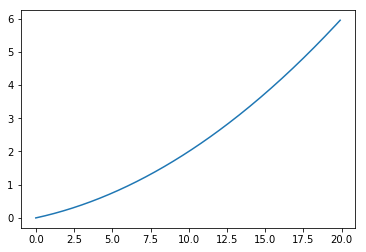

In [10]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

import numpy as np
import matplotlib.pylab as plt

x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.plot(x, y)

In [11]:
print(numerical_diff(function_1, 5))
print(numerical_diff(function_1, 10))

0.1999999999990898
0.2999999999986347


## 偏微分

In [12]:
def function_2(x):
    return x[0]**2 + x[1]**2 # おわん型立体グラフ

def function_tmp1(x0):
    return x0*x0 + 4.0*2.0
print(numerical_diff(function_tmp1, 3.0))

def function_tmp2(x1):
    return 3.0**2.0 + x1*x1
print(numerical_diff(function_tmp2, 4.0))

6.00000000000378
7.999999999999119


## 勾配

すべての変数の傾きのタプル

In [13]:
# 1つのベクトルに対する勾配を返す
def numerical_gradient_for_a_vector(f, x):
    h = 1e-4
    grad = np.zeros_like(x) # xと同じ形状の配列を生成
    
    # 全ての軸に対して傾き(微分)を求める
    for idx in range(x.size):
        # 一つの軸のみを微小に変動させ，「ほかの軸は固定する」
        # つまり，その軸の変動について計算したら，戻さないといけない
        tmp_val = x[idx]
        
        # 少し前のy
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        # 少し後ろのy
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        # それらの差分をxが動いた量で割ると傾きになる
        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val
    
    return grad

print(numerical_gradient_for_a_vector(function_2, np.array([3.0, 4.0])))
print(numerical_gradient_for_a_vector(function_2, np.array([0.0, 2.0])))
print(numerical_gradient_for_a_vector(function_2, np.array([3.0, 0.0])))

[6. 8.]
[0. 4.]
[6. 0.]


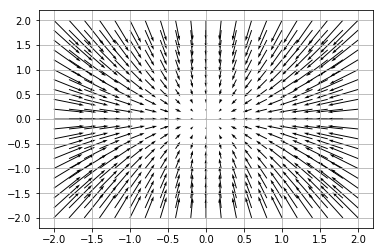

In [14]:
def numerical_gradient(f, X):
    if X.ndim == 1:
        # 入力ベクトルが１次元ならそのままfor a vectorを使う
        return numerical_gradient_for_a_vector(f, X)
    else:
        # 入力ベクトルが複数ある時は，各ベクトルについて勾配を求める
        # この場合は，flattenされたXとYについて，それぞれ勾配を求めている
        grad = np.zeros_like(X)
        for idx, x in enumerate(X):
            grad[idx] = numerical_gradient_for_a_vector(f, x) # 勾配ベクトルが返る
        
        return grad # 勾配ベクトルのベクトル(2行20列)が返る

def function_2(x):
    if x.ndim == 1:
        # 入力ベクトルが１次元なら，そのまま全要素を2乗して足して一つの値を返す
        return np.sum(x**2)
    else:
        # 入力ベクトルが[X, Y] = [[...], [...]]のように1次元でないなら，X，Y，・・・の
        # 各要素を「タテに」2乗して和を取って，1つのベクトルを返す
        # 実はこっちはこのグラフでは使われてない
        return np.sum(x**2, axis=1)

X, Y = np.meshgrid(np.arange(-2.0, 2.1, 0.2), np.arange(-2.0, 2.1, 0.2))
X = X.flatten()
Y = Y.flatten()
grad = numerical_gradient(function_2, np.array([X, Y]))
plt.quiver(X,Y,-grad[0],-grad[1],scale_units='xy', scale=10.0)
plt.grid()
plt.draw()
plt.show()

とりあえず，勾配の方向は，関数の値を最も減らす方向である！

## 勾配法

ある点から始める  
→ 勾配の方向に少し進む  
→ 進んだ先でまた勾配を求める  
→ …繰り返す  

勾配降下法

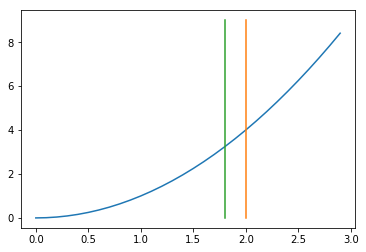

In [15]:
x = np.arange(0, 3, 0.1)
y = x ** 2
plt.plot(x, y)
plt.plot([2, 2], [0, 9])
plt.plot([1.8, 1.8], [0, 9])
plt.show()

ある点で勾配を求めた後，学習率η×勾配だけxを移動させることを繰り返す

array([-0.03458765,  0.04611686])

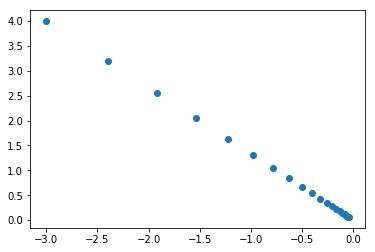

In [16]:
def gradient_descent(f, init_x, lr=0.1, step_num=20):
    x = init_x
    grads = []
    for i in range(step_num):
        grads.append(x.copy())
        grad = numerical_gradient_for_a_vector(f, x)
        x -= lr * grad # xを更新．傾きが正なら左へ，傾きが負なら右へ行けばいい．
    grads = np.array(grads)
    plt.scatter(grads[:,0], grads[:,1])
    return x

init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x)

学習率はハイパーパラメータの一つ  
大きすぎても小さすぎてもよくない

## ニューラルネットに対する勾配法

損失関数がLで与えられたとき，重みベクトルWに対する勾配は，LをWの各成分で偏微分した，Wと同じ形状のもの

In [17]:
# 確率で出してくれるやつ
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a-c)
    exp_a_sum = np.sum(exp_a)
    return exp_a / exp_a_sum

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # 2個の玉が3個の玉に向かう1層ネットワーク

    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        return loss

net = simpleNet()
print(net.W, "\n")

x = np.array([0.6, 0.9])
p = net.predict(x) # 入力に対して重みをかけた出力はどんなもん？
print(p, "\n")

print(np.argmax(p)) # 一番確率が高いやつのインデックス

t = np.array([0,0,1])
net.loss(x, t) # 正解はどうかな？

[[-0.56875312 -0.66111807  0.03740873]
 [-0.71350483  0.20698094 -0.49080342]] 

[-0.98340622 -0.21038799 -0.41927784] 

1


4.009473119059036

In [18]:
def f(W):
    # ｘの値はnumerical_gradient_for_a_vectorの中で少しいじられたあとlossが求められる．
    # xの軸の一つを少しいじってlossを求めることを各行ベクトルについて繰り返す．
    return net.loss(x,t)

dW = numerical_gradient(f, net.W) # 勾配グラフ作ったほう
print(dW)

[[-0.8344591   0.19186933  0.64258978]
 [-1.25168866  0.28780399  0.96388467]]


## 学習アルゴリズムの実装

1. 訓練データから，ランダムに一部のデータを選び出す
1. 選んだデータを入力して，すべての勾配(ベクトル)を求める
1. 全ての重みパラメータを勾配方向に微小量変化させる
1. 以上を繰り返す

無作為に選ばれたデータ使用するので，確率的勾配降下法(Statistic Gradient Descent, SGD)という.


2層ニューラルネットワークを実装してみる

In [19]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# one-hot表現
def cross_entropy_error(y, t):
    if y.ndim == 1: #データが1つの場合も要素１つの2次元配列にして対応する
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y)) / batch_size

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
    
    # Xは何個でも画像をもらえる．それぞれの画像に対する予測結果を返す．
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params["W2"]
        b1, b2 = self.params['b1'], self.params["b2"]
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        z2 = sigmoid(a2)
        y = softmax(z2)
        
        return y
    
    def loss(self, x, t):
        p = self.predict(x)
        return cross_entropy_error(p, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1) # デフォルトは縦でargmaxを求めてしまう．1行の中の最大値が推測結果．
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads["W1"] = numerical_gradient(loss_W, self.params["W1"])
        grads["b1"] = numerical_gradient(loss_W, self.params["b1"])
        grads["W2"] = numerical_gradient(loss_W, self.params["W2"])
        grads["b2"] = numerical_gradient(loss_W, self.params["b2"])
        
        return grads

In [20]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params["W1"].shape)
print(net.params["b1"].shape)
print(net.params["W2"].shape)
print(net.params["b2"].shape)

(784, 100)
(100,)
(100, 10)
(10,)


Iteration: 0 Loss: 4.604110512321279
Iteration: 1 Loss: 4.597323739596787
Iteration: 2 Loss: 4.597619195410966
Iteration: 3 Loss: 4.595745263779169
Iteration: 4 Loss: 4.598249140626203
Iteration: 5 Loss: 4.601647861367734
Iteration: 6 Loss: 4.588520515721751
Iteration: 7 Loss: 4.608432797736972
Iteration: 8 Loss: 4.596760403367078
Iteration: 9 Loss: 4.585759460229134


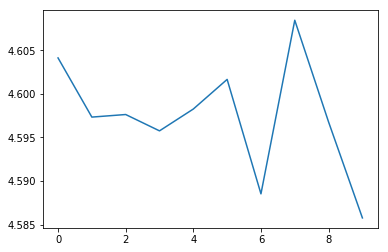

In [24]:
"""
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
train_loss_list = []

iters_num = 10
train_size = x_train.shape[0]
batch_size = 10
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.numerical_gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', "b2"):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    print("Iteration:", i, "Loss:", loss)
    train_loss_list.append(loss)

X = np.arange(0, iters_num)
plt.plot(X, train_loss_list)
"""

アホみたいに時間かかる

テストデータで評価する  
ミニバッチで使用したデータの合計が全データに上ったとき，それを1エポックという単位であらわす．  
バッチが100個，全データが10000個のとき，100回繰り返したら，1エポックになる．  
一般的に，1エポックごとにAccuracyのテストを行う模様

Iteration: 0 Loss: 4.593895369320135
Iteration: 1 Loss: 4.607194458656849
Iteration: 2 Loss: 4.598491499520608
Iteration: 3 Loss: 4.603851292236709
Iteration: 4 Loss: 4.6015700881446655
Iteration: 5 Loss: 4.601876636420679
Iteration: 6 Loss: 4.600999464374449
Iteration: 7 Loss: 4.586529720986534
Iteration: 8 Loss: 4.59368033487231
Iteration: 9 Loss: 4.612823605580028


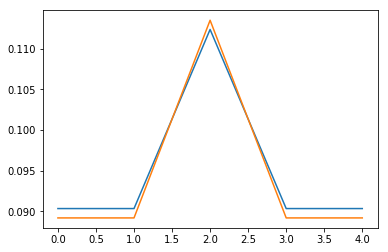

In [26]:
"""
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

iters_num = 10
train_size = x_train.shape[0]
batch_size = 10
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []
iter_per_epoch = max(train_size / batch_size, 1)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.numerical_gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', "b2"):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    print("Iteration:", i, "Loss:", loss)
    train_loss_list.append(loss)
    
    # if i % iter_per_epoch == 0:
    if i % 2 == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        

X1 = np.arange(0, len(train_acc_list))
X2 = np.arange(0, len(test_acc_list))
plt.plot(X1, train_acc_list)
plt.plot(X2, test_acc_list)
"""

精度が1に収束すれば，過学習が起きていないことになる．

## まとめ

推測：入力データ→重みをつける→出力結果  
勾配降下法による学習：推測→勾配を求める(時間かかる)→すべての重みを勾配×学習率だけ動かし，更新→繰り返す  
確率的勾配降下法：ランダムにデータを選んで行うミニバッチ学習．バッチ数×画素数が1つの入力データになり，それを学習する．  
精度テスト：1エポックに1回，すべてのデータをその時の重みで推測させてやって，どれだけ当たってるかを調べる．  

この手法だとめっちゃ時間かかる. バッチ数×画素数を，値少し変えて全部のloss, 値変えて全部のlossをやっているから．  
次章の誤差逆伝搬法では，効率的に勾配を求める．